In [107]:
import pandas as pd
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [108]:

# A dictionary mapping single-letter codes to descriptive names
feature_map = {
    'c': 'co-expression',
    'd': 'domain similarity',
    'g': 'GO semantic similarity',
    'p': 'pathway co-occurrence',
    's': 'sequence similarity'
}

def decode_relations(feature_str):
    """
    1) Split on '_' and take the second piece (index 1).
    2) If 'shuffled' appears in that piece, return 'Shuffled'.
    3) Otherwise, decode each single-letter code.
    """
    parts = feature_str.split('_')
    if len(parts) < 2:
        # If there's no second piece, just return the original string
        return feature_str
    
    second_piece = parts[1]
    
    # Decode single-letter codes
    decoded = []
    for char in second_piece.lower():
        if char in feature_map:
            decoded.append(feature_map[char])

    decoded.append('PPI')
    
    # Join the decoded feature names, or return the second piece if none matched
    return ', '.join(decoded) if decoded else second_piece

def decode_features(feature_str):
    """
    Decode the feature names in a DataFrame.
    """
    parts = feature_str.split('_')
    if len(parts) < 2:
        # If there's no second piece, just return the original string
        return 'multi-omics'
    
    third_piece = parts[2] if len(parts) > 2 else ''
    
    # Check for "shuffled" (case-insensitive)
    if 'shuffled' in third_piece.lower():
        return 'shuffled features'
    else:
        return 'multi-omics'

In [109]:
# 1. Read CSV file into a pandas DataFrame
#    Replace 'results.csv' with your actual CSV filename.
df = pd.read_csv("../results/wand_results_25.03.20.csv")

# 1.1. Rename columns from test_aupr, test_auroc, test_acc, test_f1 to AUPR, AUROC, ACC, F1
rename_dict = {
    'test_aupr': 'AUPR',
    'test_auc': 'AUROC',
    'test_accuracy': 'ACC',
    'test_f1': 'F1'
}

df.rename(columns=rename_dict, inplace=True)
df.dropna(subset=['AUPR', 'AUROC', 'ACC', 'F1'], inplace=True)

In [122]:
# 2. Filter rows so we only keep those where the Dataset name starts with "CPDB"
df_filtered = df[df["Name"].str.startswith("CPDB")]
df_filtered = df_filtered[df_filtered["Name"].str.contains("nh_32") == False]

In [123]:
# 3. Decode the features column
df_filtered["Relations"] = df_filtered["Name"].apply(decode_relations)
df_filtered["Features"] = df_filtered["Name"].apply(decode_features)

In [124]:
# 4. Group by (Dataset, Features) to aggregate multiple runs (mean and standard deviation)
agg_df = (
    df_filtered
    .groupby(["Name", "Relations", "Features"], as_index=False)
    .agg({
        "AUPR": ["mean", "std"],
        "AUROC": ["mean", "std"],
        "ACC": ["mean", "std"],
        "F1": ["mean", "std"],
    })
)

In [127]:
# Flatten the multi-index columns produced by aggregation
agg_df.columns = [
    "Dataset", 
    "Relations", 
    "Features",
    "AUPR_mean", "AUPR_std", 
    "AUROC_mean", "AUROC_std", 
    "ACC_mean", "ACC_std", 
    "F1_mean", "F1_std"
]


In [128]:
# 5. Format the metrics as "mean ± std"
def fmt_mean_std(mean_col, std_col, df, decimals=3):
    return (
        df[mean_col].round(decimals).astype(str)
        + " ± "
        + df[std_col].round(decimals).astype(str)
    )

agg_df["AUPR"] = fmt_mean_std("AUPR_mean", "AUPR_std", agg_df)
agg_df["AUROC"] = fmt_mean_std("AUROC_mean", "AUROC_std", agg_df)
agg_df["ACC"] = fmt_mean_std("ACC_mean", "ACC_std", agg_df)
agg_df["F1"] = fmt_mean_std("F1_mean", "F1_std", agg_df)


In [129]:
# 6. Select only the final columns for display
final_df = agg_df[["Relations","Features", "AUPR", "AUROC", "ACC", "F1"]]

# 7. Print the resulting table as Markdown
print(final_df.to_markdown(index=False))

| Relations                                                                                                 | Features          | AUPR          | AUROC         | ACC           | F1            |
|:----------------------------------------------------------------------------------------------------------|:------------------|:--------------|:--------------|:--------------|:--------------|
| co-expression, PPI                                                                                        | multi-omics       | 0.813 ± 0.004 | 0.871 ± 0.014 | 0.808 ± 0.012 | 0.821 ± 0.013 |
| co-expression, domain similarity, PPI                                                                     | multi-omics       | 0.822 ± 0.01  | 0.871 ± 0.01  | 0.799 ± 0.037 | 0.81 ± 0.027  |
| co-expression, domain similarity, GO semantic similarity, PPI                                             | multi-omics       | 0.898 ± 0.022 | 0.919 ± 0.01  | 0.856 ± 0.009 | 0.862 ± 0.007 |
| co-expression, domain simila

In [130]:
final_df

,Relations,Features,AUPR,AUROC,ACC,F1
0,"co-expression, PPI",multi-omics,0.813 ± 0.004,0.871 ± 0.014,0.808 ± 0.012,0.821 ± 0.013
1,"co-expression, domain similarity, PPI",multi-omics,0.822 ± 0.01,0.871 ± 0.01,0.799 ± 0.037,0.81 ± 0.027
2,"co-expression, domain similarity, GO semantic ...",multi-omics,0.898 ± 0.022,0.919 ± 0.01,0.856 ± 0.009,0.862 ± 0.007
3,"co-expression, domain similarity, GO semantic ...",multi-omics,0.919 ± 0.007,0.925 ± 0.014,0.907 ± 0.005,0.909 ± 0.005
4,"co-expression, domain similarity, GO semantic ...",multi-omics,0.917 ± 0.013,0.926 ± 0.012,0.891 ± 0.02,0.895 ± 0.02
5,"co-expression, domain similarity, GO semantic ...",shuffled features,0.863 ± 0.03,0.892 ± 0.013,0.87 ± 0.022,0.869 ± 0.025
6,"co-expression, domain similarity, GO semantic ...",multi-omics,0.889 ± 0.013,0.904 ± 0.014,0.862 ± 0.014,0.868 ± 0.012
7,"co-expression, domain similarity, pathway co-o...",multi-omics,0.871 ± 0.017,0.907 ± 0.003,0.883 ± 0.005,0.887 ± 0.003
8,"co-expression, domain similarity, pathway co-o...",multi-omics,0.87 ± 0.031,0.898 ± 0.01,0.875 ± 0.02,0.877 ± 0.02
9,"co-expression, domain similarity, sequence sim...",multi-omics,0.822 ± 0.009,0.866 ± 0.013,0.799 ± 0.012,0.805 ± 0.016


In [131]:
# Function to extract the mean value from a "mean ± std" string
def extract_mean(cell):
    try:
        return float(cell.split(" ± ")[0])
    except Exception:
        return 0

# Create a numeric DataFrame for the metric columns by extracting the mean values
numeric_df = final_df[["AUPR", "AUROC", "ACC", "F1"]].map(extract_mean)

# Updated function to compute a background color with adjustable transparency
def heatmap_color(val, vmin, vmax, cmap='YlGnBu', alpha=0.5):
    # Normalize the value between 0 and 1
    norm = (val - vmin) / (vmax - vmin) if vmax > vmin else 0.5
    rgba = matplotlib.colormaps.get_cmap(cmap)(norm)
    # Override the alpha value with our desired transparency
    r, g, b, _ = rgba
    # Return a CSS rgba color string; note alpha is a float between 0 and 1
    return f'background-color: rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, {alpha})'

# Function to style a column using its numeric version
def style_column(series, numeric_series, cmap='YlGnBu', alpha=0.5):
    vmin, vmax = numeric_series.min(), numeric_series.max()
    return [heatmap_color(val, vmin, vmax, cmap, alpha) for val in numeric_series]

# Apply the style to each of the metric columns using the numeric DataFrame for colors.
styled = final_df.style.apply(
    lambda col: style_column(col, numeric_df[col.name]) if col.name in ["AUPR", "AUROC", "ACC", "F1"] else ['']*len(col),
    subset=["AUPR", "AUROC", "ACC", "F1"]
)

# In a Jupyter Notebook, simply display the styled DataFrame:
styled

,Relations,Features,AUPR,AUROC,ACC,F1
0,"co-expression, PPI",multi-omics,0.813 ± 0.004,0.871 ± 0.014,0.808 ± 0.012,0.821 ± 0.013
1,"co-expression, domain similarity, PPI",multi-omics,0.822 ± 0.01,0.871 ± 0.01,0.799 ± 0.037,0.81 ± 0.027
2,"co-expression, domain similarity, GO semantic similarity, PPI",multi-omics,0.898 ± 0.022,0.919 ± 0.01,0.856 ± 0.009,0.862 ± 0.007
3,"co-expression, domain similarity, GO semantic similarity, pathway co-occurrence, PPI",multi-omics,0.919 ± 0.007,0.925 ± 0.014,0.907 ± 0.005,0.909 ± 0.005
4,"co-expression, domain similarity, GO semantic similarity, pathway co-occurrence, sequence similarity, PPI",multi-omics,0.917 ± 0.013,0.926 ± 0.012,0.891 ± 0.02,0.895 ± 0.02
5,"co-expression, domain similarity, GO semantic similarity, pathway co-occurrence, sequence similarity, PPI",shuffled features,0.863 ± 0.03,0.892 ± 0.013,0.87 ± 0.022,0.869 ± 0.025
6,"co-expression, domain similarity, GO semantic similarity, sequence similarity, PPI",multi-omics,0.889 ± 0.013,0.904 ± 0.014,0.862 ± 0.014,0.868 ± 0.012
7,"co-expression, domain similarity, pathway co-occurrence, PPI",multi-omics,0.871 ± 0.017,0.907 ± 0.003,0.883 ± 0.005,0.887 ± 0.003
8,"co-expression, domain similarity, pathway co-occurrence, sequence similarity, PPI",multi-omics,0.87 ± 0.031,0.898 ± 0.01,0.875 ± 0.02,0.877 ± 0.02
9,"co-expression, domain similarity, sequence similarity, PPI",multi-omics,0.822 ± 0.009,0.866 ± 0.013,0.799 ± 0.012,0.805 ± 0.016


/var/folders/fh/dk_7wcx551n03dv4ztv1_d740000gp/T/ipykernel_15180/2543446060.py:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


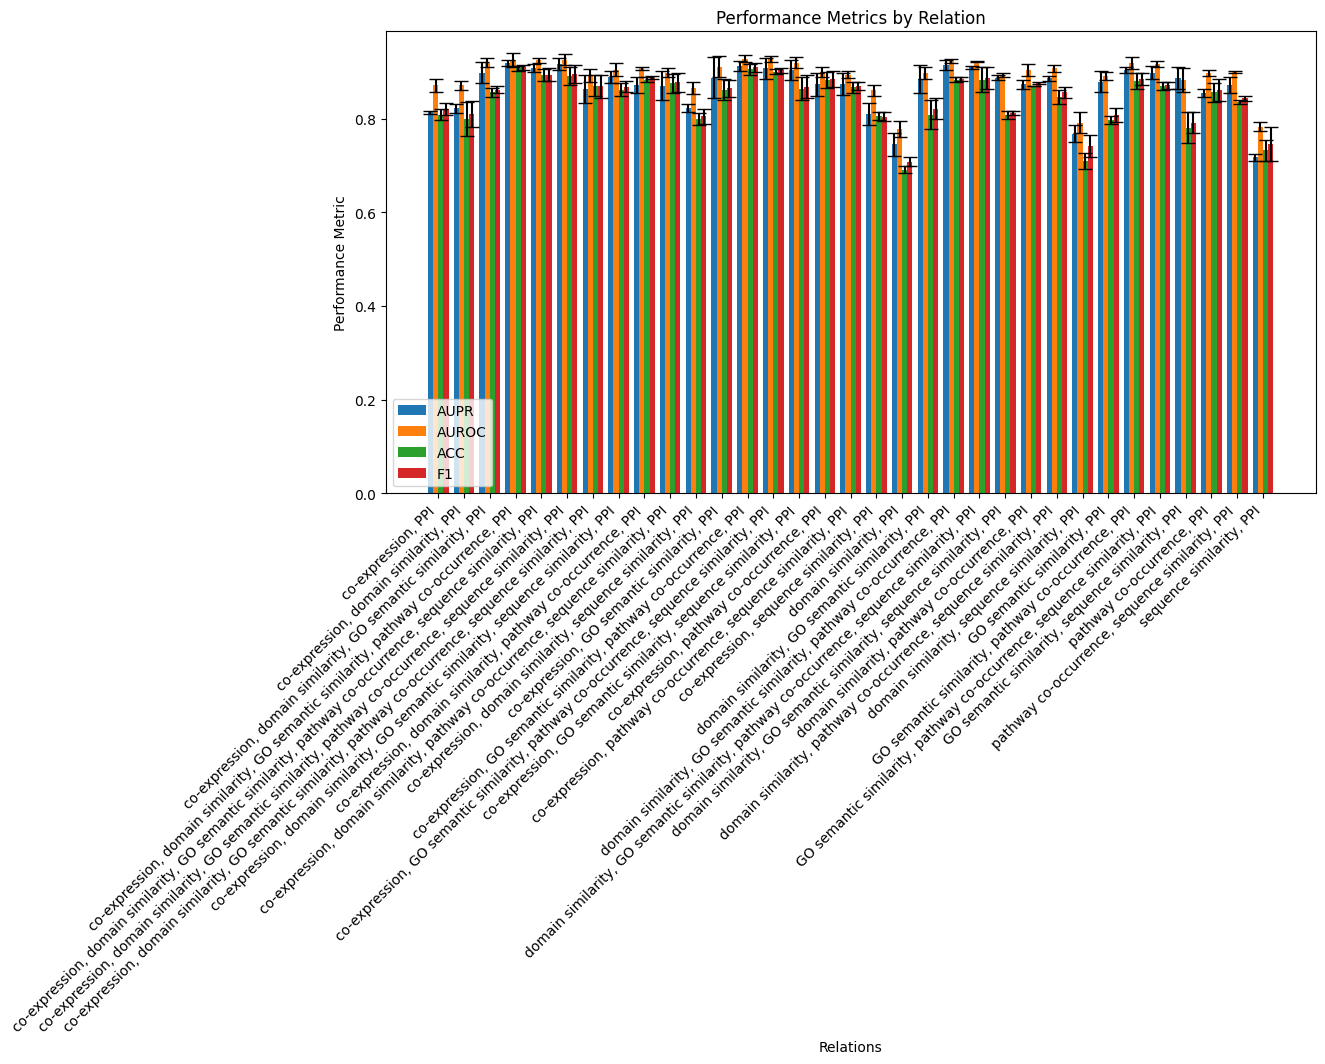

In [91]:

# Function to parse "mean ± std" strings into floats
def parse_metric(metric_str):
    mean_str, std_str = metric_str.split(" ± ")
    return float(mean_str), float(std_str)

# Extract metrics into separate lists
relations = final_df["Relations"].tolist()
AUPR_means, AUPR_stds = zip(*final_df["AUPR"].apply(parse_metric))
AUROC_means, AUROC_stds = zip(*final_df["AUROC"].apply(parse_metric))
ACC_means, ACC_stds = zip(*final_df["ACC"].apply(parse_metric))
F1_means, F1_stds = zip(*final_df["F1"].apply(parse_metric))

# Number of groups and bar settings
n_groups = len(relations)
index = np.arange(n_groups)
bar_width = 0.2

plt.figure(figsize=(12, 6))

# Create bars for each metric with error bars
plt.bar(index, AUPR_means, bar_width, yerr=AUPR_stds, capsize=5, label='AUPR')
plt.bar(index + bar_width, AUROC_means, bar_width, yerr=AUROC_stds, capsize=5, label='AUROC')
plt.bar(index + 2*bar_width, ACC_means, bar_width, yerr=ACC_stds, capsize=5, label='ACC')
plt.bar(index + 3*bar_width, F1_means, bar_width, yerr=F1_stds, capsize=5, label='F1')

plt.xlabel('Relations')
plt.ylabel('Performance Metric')
plt.title('Performance Metrics by Relation')
plt.xticks(index + 1.5*bar_width, relations, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

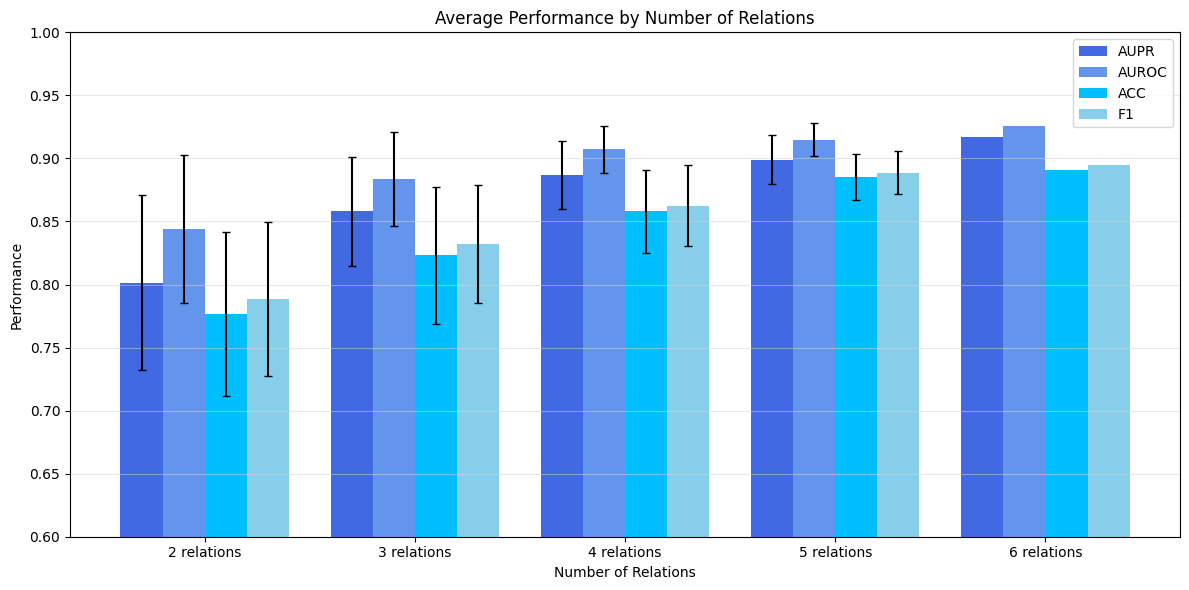

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Exclude rows with "shuffled features"
df_filtered = final_df[final_df["Features"].str.lower() != "shuffled features"].copy()

# 2. Create a new column that counts the number of relations 
# (count items from splitting the "Relations" column by commas)
df_filtered["n_relations"] = df_filtered["Relations"].apply(lambda x: len(x.split(',')))

# 3. Create new numeric columns by extracting the mean and std from the "mean ± std" strings.
for metric in ["AUPR", "AUROC", "ACC", "F1"]:
    df_filtered[f"{metric}_mean"] = df_filtered[metric].apply(lambda x: float(x.split(" ± ")[0]))
    df_filtered[f"{metric}_std"]  = df_filtered[metric].apply(lambda x: float(x.split(" ± ")[1]))

# 4. Group by the number of relations and aggregate: compute the mean of the means,
# and also compute the standard deviation across these mean values (to show variability across different relation types)
grouped = df_filtered.groupby("n_relations").agg({
    "AUPR_mean": ['mean', 'std'],
    "AUROC_mean": ['mean', 'std'],
    "ACC_mean": ['mean', 'std'],
    "F1_mean":   ['mean', 'std']
}).reset_index()

# Flatten the multi-level columns
grouped.columns = ['n_relations', 
                   'AUPR_mean', 'AUPR_std', 
                   'AUROC_mean', 'AUROC_std', 
                   'ACC_mean', 'ACC_std', 
                   'F1_mean', 'F1_std']

# 5. Create labels for the x-axis
grouped["label"] = grouped["n_relations"].apply(lambda x: f"{x} relations")

# 6. Plot the grouped bar chart with error bars for each metric
n_groups = len(grouped)
index = np.arange(n_groups)
bar_width = 0.2

plt.figure(figsize=(12, 6))

plt.bar(index, grouped["AUPR_mean"], bar_width, yerr=grouped["AUPR_std"], capsize=3, label="AUPR", color = 'royalblue')
plt.bar(index + bar_width, grouped["AUROC_mean"], bar_width, yerr=grouped["AUROC_std"], capsize=3, label="AUROC", color = 'cornflowerblue')
plt.bar(index + 2*bar_width, grouped["ACC_mean"], bar_width, yerr=grouped["ACC_std"], capsize=3, label="ACC", color = 'deepskyblue')
plt.bar(index + 3*bar_width, grouped["F1_mean"], bar_width, yerr=grouped["F1_std"], capsize=3, label="F1", color = 'skyblue')

plt.grid(axis='y', alpha=0.5, color='lightgrey')
plt.ylim(0.6,1 )
plt.xlabel("Number of Relations")
plt.ylabel("Performance")
plt.title("Average Performance by Number of Relations")
plt.xticks(index + 1.5*bar_width, grouped["label"])
plt.legend()
plt.tight_layout()
plt.show()